In [40]:
import cv2
import numpy as np
import cv2
import numpy as np
import numpy as np
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image, ImageFilter
import math
from scipy import signal as sg
import sys # to access the system
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from functools import cmp_to_key
import logging
from google.colab.patches import cv2_imshow
from numpy import isfinite
from functools import reduce


def generate_gaussian_pyramid(image, num_octaves, num_scales):
    pyramid = []
    for octave in range(num_octaves):
        octave_images = []
        for scale in range(num_scales):
            k = 2 ** (1 / num_scales)
            sigma = (k ** scale)
            blurred_image = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma, sigmaY=sigma)

            octave_images.append(blurred_image)
        #image = cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2), interpolation=cv2.INTER_LINEAR)
        pyramid.append(octave_images)
    return pyramid


def generate_difference_of_gaussian(pyramid):
    dog_pyramid = []
    for octave_images in pyramid:
        dog_octave = [octave_images[i + 1]-octave_images[i] for i in range(len(octave_images) - 1)]
        dog_pyramid.append(dog_octave)
    return dog_pyramid


def find_keypoints(dog_pyramid, threshold=0.03):
    keypoints = []

    for octave, octave_images in enumerate(dog_pyramid):
        for scale in range(1, len(octave_images) - 1):
            for i in range(1, octave_images[scale].shape[1] - 1):
                for j in range(1, octave_images[scale].shape[0] - 1):
                    patch = np.array([
                        octave_images[scale - 1][j - 1:j + 2, i - 1:i + 2],
                        octave_images[scale][j - 1:j + 2, i - 1:i + 2],
                        octave_images[scale + 1][j - 1:j + 2, i - 1:i + 2]
                    ])

                    if is_keypoint(patch, scale, i, j, octave_images, threshold):
                       keypoints.append((j, i, scale, octave))

    # Remove duplicates based on position and scale
    keypoints = list({(j, i, scale, octave): None for j, i, scale, octave in keypoints})

    return keypoints

def is_keypoint(patch, scale, i, j, octave_images, threshold):
    center_value = patch[1,1]  # Access the center value from the tuple
    if center_value.all()<0.03:
      return False
    # Check if the center pixel is an extremum
    if (center_value.all() > 0.03):
        # Compare with 26 neighbors in the current scale and adjacent scales
      neighbors = np.concatenate([
          patch[0].flatten(),
          patch[1].flatten(),
          patch[2].flatten(),

        ])
      neighbors[13] = 0  # Exclude the center pixel

      if center_value.all() == np.max(neighbors): #or center_value.all() == np.min(neighbors):
          return True
      else:
          return False



def assign_orientation(keypoints, image, sigma=1.5, num_bins=36):
    orientations = []

    for keypoint in keypoints:
        i, j, scale, octave = keypoint

        # Create a circular region around the keypoint
        radius = int(sigma * scale)
        region = cv2.getRectSubPix(image, (2*radius+1, 2*radius+1), (j, i))

        # Calculate gradient magnitude and orientation
        grad_x = cv2.Sobel(region, cv2.CV_64F, 1, 0, ksize=5)
        grad_y = cv2.Sobel(region, cv2.CV_64F, 0, 1, ksize=5)
        magnitude, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

        # Create a weighted histogram of orientations
        histogram = np.zeros(num_bins)
        bins = np.arange(0, 360, 360/num_bins)
        np.add.at(histogram, np.clip(np.digitize(angle.flatten(), bins), 0, num_bins-1), magnitude.flatten())


        # Find the dominant orientation in the histogram
        dominant_orientation = np.argmax(histogram) * (360 / num_bins)

        # Add the dominant orientation to the keypoint
        orientations.append((i, j, scale, octave, dominant_orientation))

    return orientations




def compute_sift_descriptor(keypoint, image):
    # Get keypoint coordinates
    x, y = int(keypoint[1]), int(keypoint[0])

    # Extract a patch around the keypoint
    patch_size = 16
    patch = image[y - patch_size // 2:y + patch_size // 2, x - patch_size // 2:x + patch_size // 2]
    if patch.size == 0:
            return None
    # Compute gradients using Sobel operators
    gradient_x = cv2.Sobel(patch, cv2.CV_64F, 1, 0, ksize=5)
    gradient_y = cv2.Sobel(patch, cv2.CV_64F, 0, 1, ksize=5)

    # Compute gradient magnitude and orientation
    gradient_magnitude, gradient_orientation = cv2.cartToPolar(gradient_x, gradient_y, angleInDegrees=True)

    # Divide the patch into 4x4 cells (handling unequal division)
    num_cells = 4
    cell_size = patch_size // num_cells
    cells = [patch[i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size]
             for i in range(num_cells) for j in range(num_cells)]

    # Compute histograms for each cell
    histograms = []
    for cell in cells:
        # Flatten the cell into a 1D array
        flat_cell = cell.flatten()

        # Compute histogram with 8 bins (0-360 degrees divided into 8 bins)
        hist, _ = np.histogram(flat_cell, bins=8, range=(0, 360))

        # Normalize the histogram and append to the list
        histograms.append(hist / np.sum(hist))

    # Concatenate the histograms to form the final descriptor
    descriptor = np.concatenate(histograms)

    # Threshold the descriptor to ensure robustness to lighting changes
    descriptor[descriptor > 0.2] = 0.2
    descriptor /= np.sum(descriptor)

    return descriptor

def draw_keypoints(image, keypoints):
    # Create a copy of the image to avoid modifying the original
    image_with_keypoints = image.copy()

    # Iterate through keypoints and draw circles
    for keypoint in keypoints:
        y, x, size, _,_= keypoint
        angle=keypoint[4]
        angle_rad = np.radians(angle)
        center = (int(x), int(y))  # Convert to integer coordinates
        radius = int(size / 2)

        cv2.circle(image_with_keypoints, center, 2, (0, 255, 0), 2)  # Green color, thickness=2

    return image_with_keypoints

# PCA descriptor for keypoints with orientation, method 1
# def pca_sift(X, num_components):
#     # Center the data
#     X = list(filter(lambda item: item is not None, X))
#     X = np.array(X)
#     mean = np.mean(X, axis=0)
#     X_centered = X - mean

#     # Compute the covariance matrix
#     cov_matrix = np.dot(X_centered.T, X_centered) / (X.shape[0] - 1)

#     # Perform eigendecomposition
#     eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

#     # Sort eigenvectors by decreasing eigenvalues
#     sorted_indices = np.argsort(eigenvalues)[::-1]
#     eigenvectors = eigenvectors[:, sorted_indices]

#     # Select the top 'num_components' eigenvectors
#     selected_eigenvectors = eigenvectors[:, :num_components]

#     # Project the centered data onto the selected eigenvectors
#     pca_result = reduce(np.dot, (X_centered, selected_eigenvectors))

#     return pca_result, selected_eigenvectors

def draw_arrows(image,keypoints_with_orientations):
  # Compute gradients using Sobel operators
  gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
  gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

  # Compute gradient magnitude and orientation
  gradient_magnitude, gradient_orientation = cv2.cartToPolar(gradient_x, gradient_y, angleInDegrees=True)

  # Draw keypoints with orientations on the image
  # Create a figure and axis
  fig, ax = plt.subplots(figsize=(8, 8))

  # Plot the image
  ax.imshow(image)

  # Draw arrows for each keypoint
  for keypoint in keypoints_with_orientations:
      x, y = int(keypoint[1]), int(keypoint[0])  # Keypoint coordinates
      angle = keypoint[4]  # Keypoint orientation
      #print(angle)

      # Calculate the endpoint of the arrow based on orientation
      arrow_length =  gradient_magnitude[y, x]

      endpoint_x = x + arrow_length*0.2 * np.cos(np.radians(angle))
      endpoint_y = y + arrow_length*0.2 * np.sin(np.radians(angle))

      # Draw an arrow using plt.arrow
      ax.arrow(x, y, endpoint_x - x, endpoint_y - y, color='red', head_width=2, head_length=5)

  # Set axis off
  ax.axis('off')

  # Show the plot
  plt.show()



def compute_gradients(patch):
    # Compute gradients using Sobel operators
    gradient_x = cv2.Sobel(patch, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(patch, cv2.CV_64F, 0, 1, ksize=3)
    return gradient_x, gradient_y

def extract_patches_and_gradients(image, keypoints, patch_size):
    patches = []
    gradients = []

    half_patch_size = patch_size // 2

    for keypoint in keypoints:
        x, y = int(keypoint[0]), int(keypoint[1])

        # Ensure that the patch remains within the image boundaries
        patch = image[max(y - half_patch_size, 0):min(y + half_patch_size + 1, image.shape[0]),
                      max(x - half_patch_size, 0):min(x + half_patch_size + 1, image.shape[1])]

        # If the patch is smaller than the specified size, pad it with zeros
        if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
            patch = np.pad(patch, ((0, max(0, patch_size - patch.shape[0])),
                                   (0, max(0, patch_size - patch.shape[1]))), 'constant', constant_values=0)

        # Compute gradients for the patch
        gradient_x, gradient_y = compute_gradients(patch)

        # Flatten and concatenate gradients
        flattened_gradients = np.concatenate([gradient_x.flatten(), gradient_y.flatten()])

        patches.append(patch)
        gradients.append(flattened_gradients)

    return patches, gradients

def draw_patches(image, keypoints, patch_size):
    drawn_image = image.copy()
    half_patch_size = patch_size // 2

    for keypoint in keypoints:
        x, y = int(keypoint[1]), int(keypoint[0])

        # Calculate patch boundaries
        top_left = (max(x - half_patch_size, 0), max(y - half_patch_size, 0))
        bottom_right = (min(x + half_patch_size + 1, image.shape[1]), min(y + half_patch_size + 1, image.shape[0]))

        # Draw rectangle around the patch
        cv2.rectangle(drawn_image, top_left, bottom_right, (0, 255, 0), 2)  # Green color, thickness=2

    return drawn_image


#PCA

def pca(X, num_components,num_keypoints=20):
    # Center the data
    mean = np.mean(X, axis=0)
    X_centered = X - mean

    # Compute the covariance matrix
    cov_matrix = np.dot(X_centered.T, X_centered) / (X.shape[0] - 1)

    # Perform eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Sort eigenvectors by decreasing eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Select the top 'num_components' eigenvectors
    selected_eigenvectors = eigenvectors[:, :num_components]

    # Project the centered data onto the selected eigenvectors
    pca_result = np.dot(X_centered, selected_eigenvectors)
    magnitudes = np.linalg.norm(pca_result, axis=0)
    pca_result=pca_result/magnitudes
        # Find indices of top influential keypoints
# Find indices of top influential keypoints in descending order
    keypoint_indices = np.argpartition(magnitudes, -num_keypoints)[-num_keypoints:]

    # Extract corresponding keypoints from original data
    keypoints = X[keypoint_indices]

    return pca_result, selected_eigenvectors,keypoint_indices





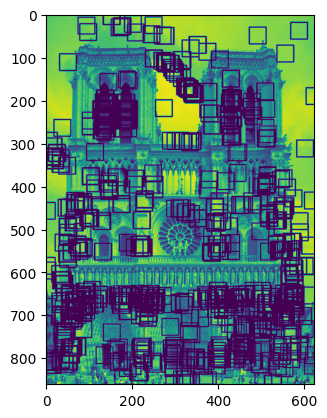

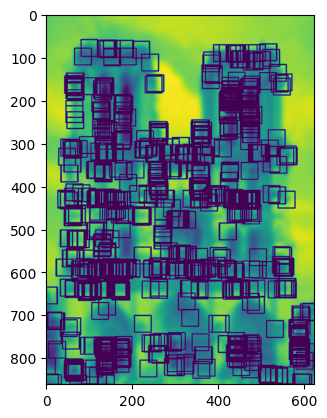

<class 'numpy.ndarray'>
(8720, 20)


<ipython-input-41-2e07c91b0e8b>:76: ComplexWarning: Casting complex values to real discards the imaginary part
  descriptors_original=np.array(descriptors_original,dtype=np.float32)
<ipython-input-41-2e07c91b0e8b>:77: ComplexWarning: Casting complex values to real discards the imaginary part
  descriptors_modified=np.array(descriptors_modified,dtype=np.float32)


Number of keypoints for modified image (8200, 5)
Number of keypoints for original image (8720, 5)


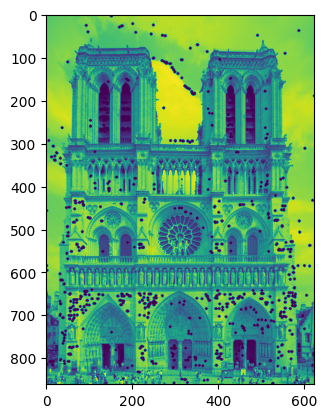

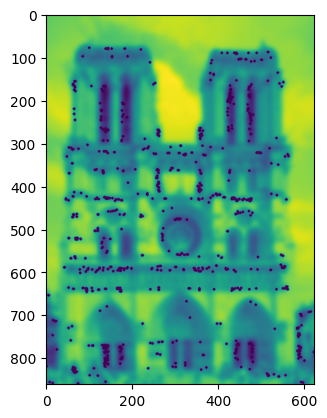

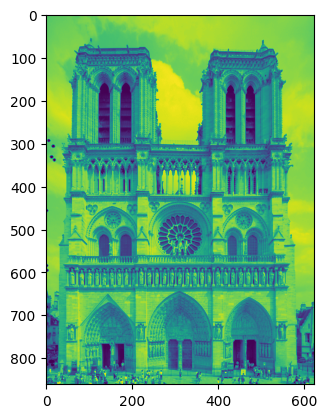

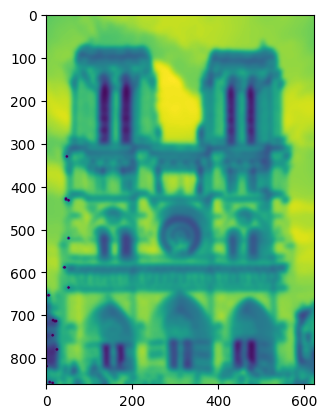

[19  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18  0]


In [41]:
# Main function

import cv2
import numpy as np
from matplotlib import pyplot as plt
import random



# Load the original image
image_path='/content/drive/MyDrive/AIP/Assignment_1/q1/img1.png';
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
original_image = resize(original_image, (0, 0), fx=0.5, fy=0.5, interpolation=INTER_LINEAR)

num_octaves_1 = int(round(log(min(original_image.shape)) / log(2) - 1))

# Modify the image by scaling, rotation, and Gaussian blur
scale_factor = 1
rotation_angle = 0
blur_sigma = 6

#Other parameters
threshold=0.03
patch_size=39
num_components=20 # For PCA
num_keypoints=20 # For selecting dominant keypoints

original_image1 = Image.open(image_path)
modified_image_t = (original_image1.rotate(rotation_angle, expand=True))
bbox = modified_image_t.getbbox()
modified_image = modified_image_t.crop(bbox)
modified_image=np.array(modified_image_t.convert('L'))
modified_image = resize(modified_image, (0, 0), fx=0.5*scale_factor, fy=0.5*scale_factor, interpolation=INTER_LINEAR)   # 0.5 for preprocessing
modified_image=cv2.GaussianBlur(modified_image,(0,0),blur_sigma)
num_octaves_2 = int(round(log(min(modified_image.shape)) / log(2) - 1))
gaussian_pyramid_original = generate_gaussian_pyramid(original_image, num_octaves_1, 4)
dog_pyramid_original = generate_difference_of_gaussian(gaussian_pyramid_original)
gaussian_pyramid_modified = generate_gaussian_pyramid(modified_image, num_octaves_2, 4)
dog_pyramid_modified = generate_difference_of_gaussian(gaussian_pyramid_modified)

# Find keypoints
original_keypoints = find_keypoints(dog_pyramid_original, threshold)
modified_keypoints = find_keypoints(dog_pyramid_modified, threshold)

# Display the original and modified images with keypoints
#original_kp_o=original_keypoints;
#modified_kp_o=modified_keypoints;

original_kp_o=assign_orientation(original_keypoints,original_image)
modified_kp_o=assign_orientation(modified_keypoints,modified_image)
#draw_arrows(original_image,original_kp_o)
#draw_arrows(modified_image,modified_kp_o)


##PCA and matching
patches_original,gradients_original=extract_patches_and_gradients(original_image,original_kp_o,patch_size);
image_with_rectangles_original = draw_patches(original_image, original_kp_o, patch_size)

# Diplay patches
plt.imshow(image_with_rectangles_original)
plt.show()

patches_modified,gradients_modified=extract_patches_and_gradients(modified_image,modified_kp_o,patch_size);
image_with_rectangles_modified = draw_patches(modified_image, modified_kp_o, patch_size)

# Diplay patches
plt.imshow(image_with_rectangles_modified)
plt.show()

descriptors_original, selected_eigenvectors, dom1 = pca(np.array(gradients_original), num_components)
descriptors_modified, selected_eigenvectors1,dom2= pca(np.array(gradients_modified), num_components)
print(type(descriptors_original))
print(np.shape(descriptors_original))

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
descriptors_original=np.array(descriptors_original,dtype=np.float32)
descriptors_modified=np.array(descriptors_modified,dtype=np.float32)
# Match descriptors
matches = bf.match(descriptors_original,descriptors_modified)

matches = sorted(matches, key=lambda x: x.distance)
# Create OpenCV KeyPoint objects from your keypoints
cv_keypoints_original = [cv2.KeyPoint(y, x, 1) for x, y, _, _,_ in original_kp_o]
cv_keypoints_rotated = [cv2.KeyPoint(y, x, 1) for x, y, _, _,_ in modified_kp_o]

#Lowe's ratio test
# Apply ratio test to filter out good matches
good_matches = []
for m in matches:
    if m.distance < 0.75 * matches[0].distance:
        good_matches.append(m)

# Create a matches mask
matches_mask = np.zeros(len(good_matches)).tolist()
matching_result = cv2.drawMatchesKnn(original_image, cv_keypoints_original, modified_image, cv_keypoints_rotated, [good_matches], None, matchesMask=matches_mask)


# Draw lines between matched keypoints
for match in matches:
    # Get the keypoints indices from the match
    query_idx = match.queryIdx
    train_idx = match.trainIdx

    # Get the keypoint coordinates in both images
    pt1 = tuple(map(int, cv_keypoints_original[query_idx].pt))
    pt2 = tuple(map(int, cv_keypoints_rotated[train_idx].pt))

    # Shift the x-coordinate of the second point to account for the offset in the combined image
    pt2_shifted = (pt2[0] + original_image.shape[1],pt2[1])
    # Generate a random color
    line_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

    # Draw a line between the keypoints with the random color
    cv2.line(matching_result, pt1, pt2_shifted, line_color, 2)  # Line thickness=1

# Display the result
scale_factor = 1  # Adjust the scale factor as needed
matching_result = cv2.resize(matching_result, (0, 0), fx=scale_factor, fy=scale_factor)

plt.imshow(matching_result)


print('Number of keypoints for modified image',np.shape(modified_kp_o))
print('Number of keypoints for original image',np.shape(original_kp_o))

# Plot for all keypoints
image_with_key_points_original=draw_keypoints(original_image, original_kp_o)
image_with_key_points_modified=draw_keypoints(modified_image, modified_kp_o)
plt.imshow(image_with_key_points_original)
plt.show()
plt.imshow(image_with_key_points_modified)
plt.show()



